### Import Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # type: ignore
plt.rcParams['axes.unicode_minus'] = False
import numpy as np # type: ignore
import pandas as pd # type: ignore
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm # type: ignore
from factor_analyzer import FactorAnalyzer # type: ignore
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo # type: ignore
from graphviz import Digraph # type: ignore
from scipy.optimize import minimize # type: ignore
from scipy.stats import stats # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from semopy import Model, Optimizer, semplot # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, Dataset # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from tqdm import tqdm # type: ignore
from argparse import Namespace

### Data Directory

In [3]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Factor Model

In [4]:
df = pd.read_csv(feature_path)[1:4].T.dropna()
df.columns = df.iloc[0]
df = df.iloc[1:].astype(float)
data = pd.read_csv(region_feature_path)[:17].T.dropna()
data.columns = data.iloc[0]
data = data.iloc[1:].astype(float)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)

Bartlett's test p-value: 0.0
KMO test: 0.8411609718819952


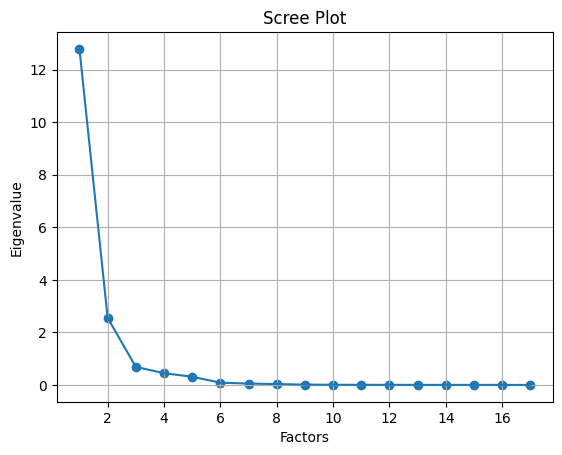

Optimal number of factors (Elbow Method): 1
Number of factors according to Kaiser Criterion: 2


In [6]:
# Conformity test for common factor analysis (Bartlett's sphericity test, KMO test)
chi_square_value, p_value = calculate_bartlett_sphericity(data_train)
kmo_all, kmo_model = calculate_kmo(data_train)

print("Bartlett's test p-value:", p_value)
print("KMO test:", kmo_model)

# Common factor analysis
# Run a scree test to determine the number of factors
fa = FactorAnalyzer(rotation=None, method='principal', n_factors=data_train.shape[1])
fa.fit(data_train)
ev, v = fa.get_eigenvalues()

# Eigenvalue graph
plt.scatter(range(1, data_train.shape[1]+1), ev)
plt.plot(range(1, data_train.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Select the point where 'elbow' appears in the above graph as the number of factors
# Calculate differences of eigenvalues
ev_diff = np.diff(ev)
# Find the point where the difference value is minimum (the 'elbow' point just before this point)
elbow_point = np.argmin(ev_diff) + 1  # Index Correction
print("Optimal number of factors (Elbow Method):", elbow_point)
# Calculate the number of factors with eigenvalues ​​greater than 1
n_factors_kaiser = (ev > 1).sum()
print("Number of factors according to Kaiser Criterion:", n_factors_kaiser)

Factor Loadings:
                                              0         1
Date                                                    
Seoul_apartment_sale_price_index      0.007446  1.006327
Busan_apartment_sale_price_index      0.719938  0.674877
Daegu_apartment_sale_price_index      0.598221  0.714891
Incheon_apartment_sale_price_index    0.150349  0.740936
Gwangju_apartment_sale_price_index    0.581617  0.774772
Daejeon_apartment_sale_price_index    0.539736  0.747848
Ulsan_apartment_sale_price_index      0.885696  0.417880
Sejong_apartment_sale_price_index     0.428811  0.727391
Gyeonggi_apartment_sale_price_index   0.126231  0.906564
Gangwon_apartment_sale_price_index    0.742842  0.612136
Chungbuk_apartment_sale_price_index   0.979413  0.197577
Chungnam_apartment_sale_price_index   0.966087  0.183671
Jeonbuk_apartment_sale_price_index    0.843762  0.399064
Jeonnam_apartment_sale_price_index    0.646887  0.704552
Gyeongbuk_apartment_sale_price_index  0.932989  0.194081
Gyeongnam_apa

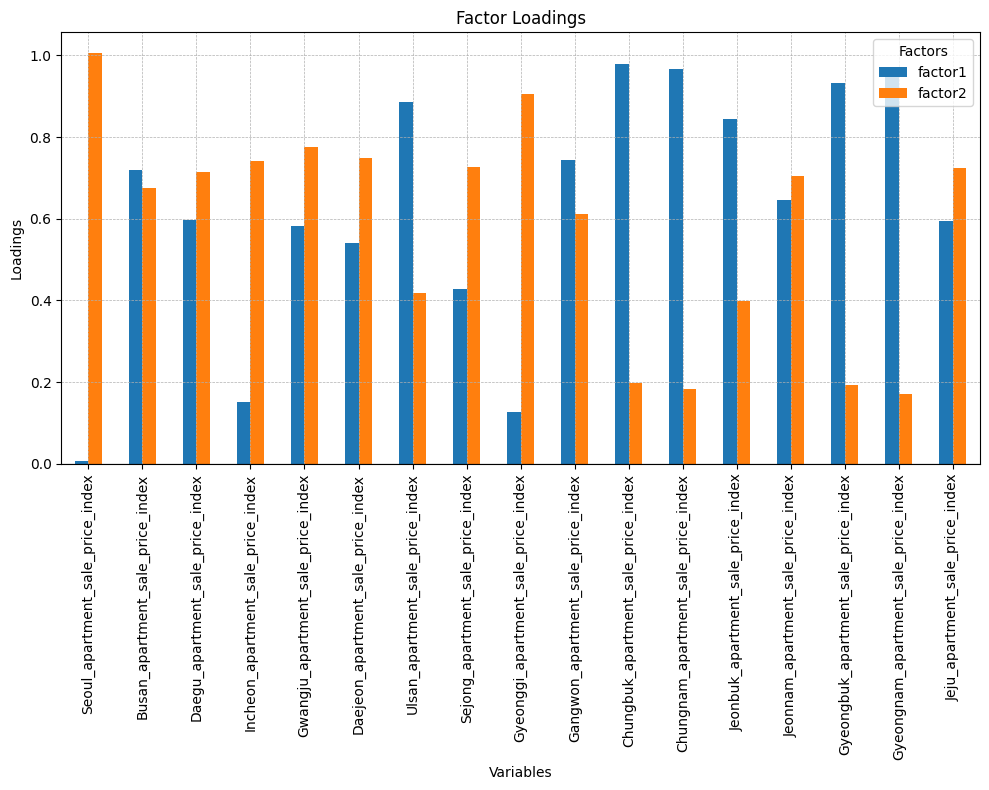

In [7]:
# Factor Analyze
fa = FactorAnalyzer(rotation='varimax', n_factors=2)
fa.fit(data_train)
loads = fa.loadings_
print("Factor Loadings:\n", pd.DataFrame(loads, index=data_train.columns))

variances = fa.get_factor_variance()
print("Factor Variances:", variances) 

loadings = pd.DataFrame(fa.loadings_, index=data_train.columns)
loadings.columns = ['factor1','factor2']

# Factor Loading Plot
fig, ax = plt.subplots(figsize=(10, 8))
loadings.plot(kind='bar', ax=ax)
ax.set_title('Factor Loadings')
ax.set_ylabel('Loadings')
ax.set_xlabel('Variables')
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Factors')
plt.tight_layout()
plt.show()

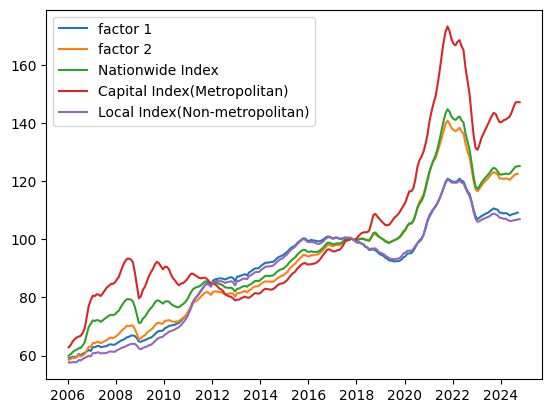

In [8]:
plt.plot(pd.to_datetime(data.index),(data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142],label="factor 1")
plt.plot(pd.to_datetime(data.index),(data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142],label="factor 2")
plt.plot(pd.to_datetime(df.index),df.iloc[:,0].values, label="Nationwide Index")
plt.plot(pd.to_datetime(df.index),df.iloc[:,1].values, label="Capital Index(Metropolitan)")
plt.plot(pd.to_datetime(df.index),df.iloc[:,2].values, label="Local Index(Non-metropolitan)")
plt.legend()
plt.show()

In [9]:
factor1 = (data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142]
factor2 = (data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142]

### Load Dataset

In [10]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

In [11]:
column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

In [12]:
df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
factor_df = pd.DataFrame([])
factor_df["factor1"] = factor1
factor_df["factor2"] = factor2
factor_df = factor_df.iloc[:-1,:]
factor_df = factor_df.dropna()
df = pd.concat([df,factor_df],axis=1) 
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()
x_df = df[column]

# train : test = 8 : 2
X_train, X_test = train_test_split(x_df, test_size=0.2, shuffle=False)


### Granger Causality Test to define model spec of SEM

In [13]:
def adf_test(series, name=''):
    if series.isnull().any() or np.isinf(series).any():
        print(f"Error: {name} contains NaN or infinite values which must be cleaned before ADF test.")
        return False
    r = adfuller(series, autolag='AIC')
    p_value = r[1]
    print(f'ADF Statistic for {name}: {r[0]:.4f}')
    print(f'p-value for {name}: {p_value:.4f}')
    return p_value < 0.05

# Make Stationary
def process_series(series, name):
    print(f"\nProcessing {name}")
    if adf_test(series, name):
        print(f"{name} is already stationary.")
        return series
    
    # First Difference
    diff = series.diff().dropna()
    if diff.empty or not adf_test(diff, f'{name}_1st_diff'):
        # Second Difference
        diff2 = diff.diff().dropna()
        if diff2.empty or not adf_test(diff2, f'{name}_2nd_diff'):
            print(f"{name} is still non-stationary after all transformations.")
            return None
        else:
            print(f"{name}_2nd_diff is now stationary.")
            return diff2
    else:
        print(f"{name}_1st_diff is now stationary.")
        return diff

results = {}
for name, column in X_train.items():
    result = process_series(column, name)
    if result is not None:
        results[f"{name}"] = result 
        
stationary_df = pd.DataFrame(results)



Processing call_interest_rate
ADF Statistic for call_interest_rate: -1.5869
p-value for call_interest_rate: 0.4902
ADF Statistic for call_interest_rate_1st_diff: -5.9949
p-value for call_interest_rate_1st_diff: 0.0000
call_interest_rate_1st_diff is now stationary.

Processing government_bond_3yr
ADF Statistic for government_bond_3yr: -0.5966
p-value for government_bond_3yr: 0.8718
ADF Statistic for government_bond_3yr_1st_diff: -4.3003
p-value for government_bond_3yr_1st_diff: 0.0004
government_bond_3yr_1st_diff is now stationary.

Processing deposit_bank_loan_rate_avg
ADF Statistic for deposit_bank_loan_rate_avg: -0.6401
p-value for deposit_bank_loan_rate_avg: 0.8617
ADF Statistic for deposit_bank_loan_rate_avg_1st_diff: -8.2294
p-value for deposit_bank_loan_rate_avg_1st_diff: 0.0000
deposit_bank_loan_rate_avg_1st_diff is now stationary.

Processing KOSPI_index
ADF Statistic for KOSPI_index: -2.1641
p-value for KOSPI_index: 0.2195
ADF Statistic for KOSPI_index_1st_diff: -11.0249
p-va

In [14]:
stationary_df_dropna = stationary_df.dropna()
granger_value = {}
# 그레인저 인과성 테스트 함수 및 최소 p-value 래그 저장
def granger_test(data, target, maxlag=12):
    min_p_values = {}
    for col in data.columns:
        if col != target:
            test_result = grangercausalitytests(data[[target, col]], maxlag=maxlag, verbose=False)
            min_p_value = float('inf')
            min_p_lag = 0
            for lag, result in test_result.items():
                p_value = result[0]['ssr_chi2test'][1]  # p-value
                if p_value < min_p_value:
                    min_p_value = p_value
                    min_p_lag = lag
            if min_p_value < 0.05:
                min_p_values[col] = min_p_lag # round(min_p_value,3))
    granger_value[target] = min_p_values
    return min_p_values

for col in X_train.columns:
    anw = granger_test(X_train, col, 23)

In [15]:
granger_value

{'call_interest_rate': {'government_bond_3yr': 11,
  'deposit_bank_loan_rate_avg': 23,
  'KOSPI_index': 1,
  'KOSDAQ_index': 1,
  'M2_Korea': 23,
  'M2_USA': 22,
  'broad_liquidity': 22,
  'CPI_growth_rate': 22,
  'USD_KRW_exchange_rate': 1,
  'real_GDP_growth_rate': 1,
  'residential_building_start_status': 20,
  'residential_building_permit_status': 23,
  'construction_production_index_seasonally_adjusted': 23},
 'government_bond_3yr': {'call_interest_rate': 16,
  'deposit_bank_loan_rate_avg': 15,
  'KOSPI_index': 20,
  'KOSDAQ_index': 4,
  'M2_Korea': 4,
  'M2_USA': 3,
  'broad_liquidity': 20,
  'USD_KRW_exchange_rate': 5,
  'real_GDP_growth_rate': 17,
  'residential_building_permit_status': 23,
  'construction_production_index_seasonally_adjusted': 22},
 'deposit_bank_loan_rate_avg': {'call_interest_rate': 11,
  'government_bond_3yr': 14,
  'KOSPI_index': 13,
  'KOSDAQ_index': 1,
  'M2_Korea': 23,
  'M2_USA': 2,
  'broad_liquidity': 20,
  'USD_KRW_exchange_rate': 5,
  'real_GDP_gro

In [16]:
print("interest_rate")
print(set.intersection(
                set(granger_value['call_interest_rate'].keys()),
                set(granger_value['government_bond_3yr'].keys()),
                set(granger_value['deposit_bank_loan_rate_avg'].keys())))
print("-----------")
print("stock")
print(set.intersection(
                set(granger_value['KOSPI_index'].keys()),
                set(granger_value['KOSDAQ_index'].keys()),
                set(granger_value['NASDAQ_index'].keys())))
print("-----------")
print("money_supply")
print(set.intersection(
                set(granger_value["M2_Korea"].keys()),
                set(granger_value["M2_USA"].keys())))
print("-----------")
print("construction")
print(set.intersection(
                set(granger_value["residential_building_start_status"].keys()),
                set(granger_value["residential_building_permit_status"].keys())))



interest_rate
{'M2_USA', 'KOSDAQ_index', 'broad_liquidity', 'real_GDP_growth_rate', 'construction_production_index_seasonally_adjusted', 'M2_Korea', 'USD_KRW_exchange_rate', 'residential_building_permit_status', 'KOSPI_index'}
-----------
stock
{'government_bond_3yr', 'deposit_bank_loan_rate_avg', 'M2_USA', 'broad_liquidity', 'real_GDP_growth_rate', 'call_interest_rate', 'M2_Korea', 'CPI_growth_rate', 'USD_KRW_exchange_rate'}
-----------
money_supply
{'government_bond_3yr', 'NASDAQ_index', 'KOSDAQ_index', 'real_GDP_growth_rate', 'construction_production_index_seasonally_adjusted', 'call_interest_rate', 'USD_KRW_exchange_rate', 'KOSPI_index'}
-----------
construction
{'government_bond_3yr', 'deposit_bank_loan_rate_avg', 'KOSDAQ_index', 'call_interest_rate', 'M2_Korea', 'CPI_growth_rate', 'KOSPI_index'}


In [17]:
# Define the SEM model specification in semopy syntax
mod_spec = f"""
    # Measurement model
    interest_rate =~ call_interest_rate + government_bond_3yr + deposit_bank_loan_rate_avg
    stock =~ KOSPI_index + KOSDAQ_index + NASDAQ_index
    money_supply =~ M2_Korea + M2_USA
    liquidity =~ broad_liquidity
    inflation =~ CPI_growth_rate
    exchange_rate =~ USD_KRW_exchange_rate
    gdp =~ real_GDP_growth_rate
    construction =~ residential_building_start_status + residential_building_permit_status
    construction_production =~ construction_production_index_seasonally_adjusted

    # Structural model
    interest_rate ~ gdp + liquidity + construction_production + money_supply + exchange_rate
    stock ~ liquidity + interest_rate + gdp + money_supply + inflation + exchange_rate
    money_supply ~ gdp + exchange_rate + stock + construction_production
    liquidity ~ interest_rate + money_supply + inflation + exchange_rate + gdp
    inflation ~ interest_rate + stock + liquidity + exchange_rate + gdp + construction_production
    exchange_rate ~ money_supply + liquidity + gdp
    gdp ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + construction_production
    construction ~ interest_rate + inflation
    construction_production ~ interest_rate + stock + liquidity + inflation + exchange_rate + gdp + construction
"""
spec = mod_spec + """
    factor ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + \
            gdp +\
            construction + construction_production # + housing_construction
    """

### SEM

In [18]:
def z_transform(X, mu, std):
    """
    ==========================
    | X: df, mu: df, std: df |
    ==========================
    """
    return (X-mu)/(std+0.000001)

def inv_z_transform(y, mu, std):
    """
    ====================================
    | y: ndarray, mu: df, std: df      |
    ====================================
    """
    return y * (std+0.000001) + mu

In [19]:
lag = 3 # 3-month ahead

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production
    
df = df[column]
df = df.shift(lag) # predict the future by taking past data of explanatory variables
df = df.dropna()
factor_df = pd.DataFrame([])
factor_df["factor1"] = factor1
factor_df["factor2"] = factor2
factor_df = factor_df.iloc[:-1,:]
factor_df = factor_df.dropna()
df = pd.concat([df,factor_df],axis=1) 
df = df[18:]
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [20]:
# target = "factor1"
def train_sem(target_value): 
    x_df = df[column]
    y_df = df[target_value]

    # train : valid : test = 6 : 2 : 2
    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.4, shuffle=False)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

    x_df_mu, x_df_std = X_train.mean(), X_train.std()
    y_df_mu, y_df_std = y_train.mean(), y_train.std()

    X_train = z_transform(X_train, x_df_mu, x_df_std)
    X_valid = z_transform(X_valid, x_df_mu, x_df_std)
    X_test = z_transform(X_test, x_df_mu, x_df_std)
    y_train = z_transform(y_train, y_df_mu, y_df_std)
    y_valid = z_transform(y_valid, y_df_mu, y_df_std)
    y_test = z_transform(y_test, y_df_mu, y_df_std)

    df_train_inv = pd.concat([pd.DataFrame(y_train), X_train], axis=1)
    df_valid_inv = pd.concat([pd.DataFrame(y_valid), X_valid], axis=1)
    df_test_inv = pd.concat([pd.DataFrame(y_test), X_test], axis=1)
    
    # Instantiate and fit the model
    spec = mod_spec + f"""
    {target_value} ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + \
            gdp +\
            construction + construction_production # + housing_construction
    """
    model = Model(spec)

    optimization_methods = ['MLW', 'ULS', 'GLS', 'WLS', 'DWLS', 'FIML']
    best_method = ''
    lowest_rmse = float('inf')

    for method in optimization_methods:
        model = Model(spec)
        try:
            model.fit(data=df_train_inv, obj=method)
            estimates = model.inspect()
            y_pred_valid = model.predict(df_valid_inv.drop(target_value, axis=1))[target_value]
            mse = mean_squared_error(df_valid_inv[target_value], y_pred_valid)
            if mse < lowest_rmse:
                lowest_rmse = mse
                best_method = method

        except Exception as e:
            # 오류가 발생했을 때 실행될 코드
            print(f"An error occurred: {e} in {method}")
        continue

    print(f"Best optimization method: {best_method} with MSE: {lowest_rmse:.4f}")
    model = Model(spec)
    opt_res = model.fit(data = df_train_inv,
                        obj = best_method)
                                    # "MLW" (the default): Wishart loglikelihood;
                                    # "ULS": Unweighted Least Squares;
                                    # "GLS": Generalized Least Squares;
                                    # "WLS": Weighted Least Squares (also known as an Asymptotic Distribution-Free Estimator);
                                    # "DWLS": Diagonally Weighted Least Squares (also known as robust WLS);
                                    # "FIML": Full Information Maximum Likelihood (when data has no missing values FIML is effectively a Multivariate Normal Maximum Likelihood).
    estimates = model.inspect()
    

    y_pred_train = model.predict(df_train_inv.drop(target_value, axis=1))[target_value]
    y_pred_valid = model.predict(df_valid_inv.drop(target_value, axis=1))
    y_pred = model.predict(df_test_inv.drop(target_value, axis=1))
    results_df = pd.DataFrame({
        'Actual': df_test_inv[target_value],
        'Predicted': y_pred[target_value]
    })

    # accuracy assessment
    results_df = results_df.dropna()
    mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df_train_inv.index),y_train,c="b")
    plt.plot(pd.to_datetime(df_train_inv.index),y_pred_train,c="r")
    plt.plot(pd.to_datetime(df_valid_inv.index), df_valid_inv[target_value], c="b")
    plt.plot(pd.to_datetime(df_valid_inv.index), y_pred_valid[target_value],c="r")
    plt.plot(pd.to_datetime(df_test_inv.index), df_test_inv[target_value], label='Actual',c="b")
    plt.plot(pd.to_datetime(df_test_inv.index), y_pred[target_value], label='Predicted',c="r")
    plt.axvline(x=pd.to_datetime(y_valid.index[0]), color='black', linestyle=':', linewidth=3)
    plt.axvline(x=pd.to_datetime(y_test.index[0]), color='black', linestyle=':', linewidth=3)
    plt.title('Actual vs Predicted Factor')
    plt.xlabel('Observations')
    plt.ylabel('Factor')
    plt.legend()
    plt.show()
    
    return pd.concat([inv_z_transform(y_pred_train, y_df_mu, y_df_std),
                      inv_z_transform(y_pred_valid[target_value], y_df_mu, y_df_std),
                      inv_z_transform(y_pred[target_value], y_df_mu, y_df_std)])

In [21]:
# Initialize Digraph from graphviz
dot = Digraph(comment='SEM Model')

# Parse model spec and create nodes and edges
lines = spec.split("\n")
for line in lines:
    line = line.strip()
    if line.endswith('=~'):
        continue
    if '=~' in line:
        latent, indicators = line.split('=~')
        latent = latent.strip()
        indicators = [ind.strip() for ind in indicators.split('+')]
        dot.node(latent, latent, shape='ellipse', color='lightblue')
        for indicator in indicators:
            dot.node(indicator, indicator, shape='box')
            dot.edge(latent, indicator, dir='none')
    elif '~' in line:
        outcome, predictors = line.split('~')
        outcome = outcome.strip()
        predictors = [pred.strip() for pred in predictors.split('+')]
        for predictor in predictors:
            if predictor:
                dot.edge(predictor, outcome)

# Render the graph
output_path = 'sem_model'
dot.render(output_path, format='png', view=True)


'sem_model.png'

Best optimization method: WLS with MSE: 0.0667
Mean Squared Error (MSE): 0.3476
R-squared (R²): -2.0594


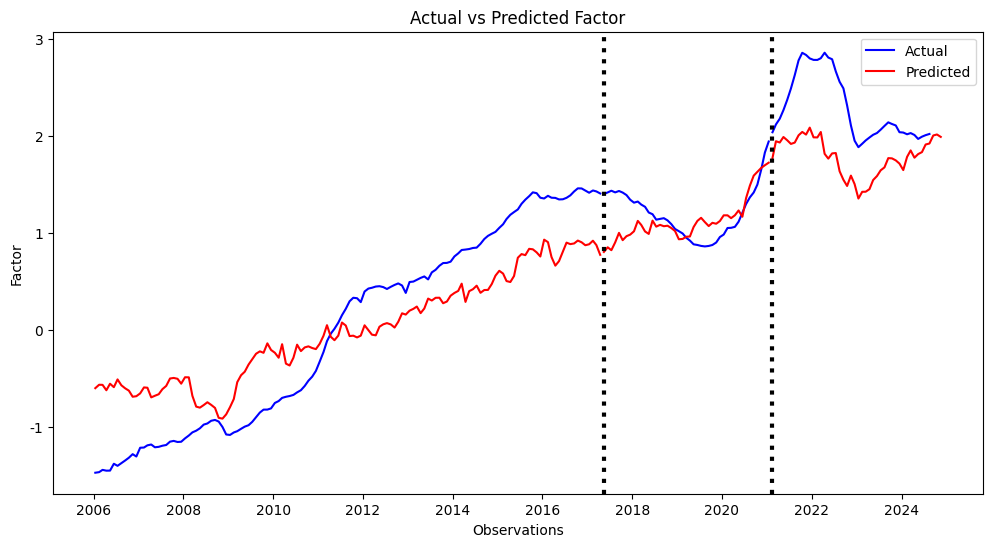

In [22]:
factor1_df = train_sem("factor1")

Best optimization method: FIML with MSE: 0.1077


Mean Squared Error (MSE): 0.3900
R-squared (R²): 0.1478


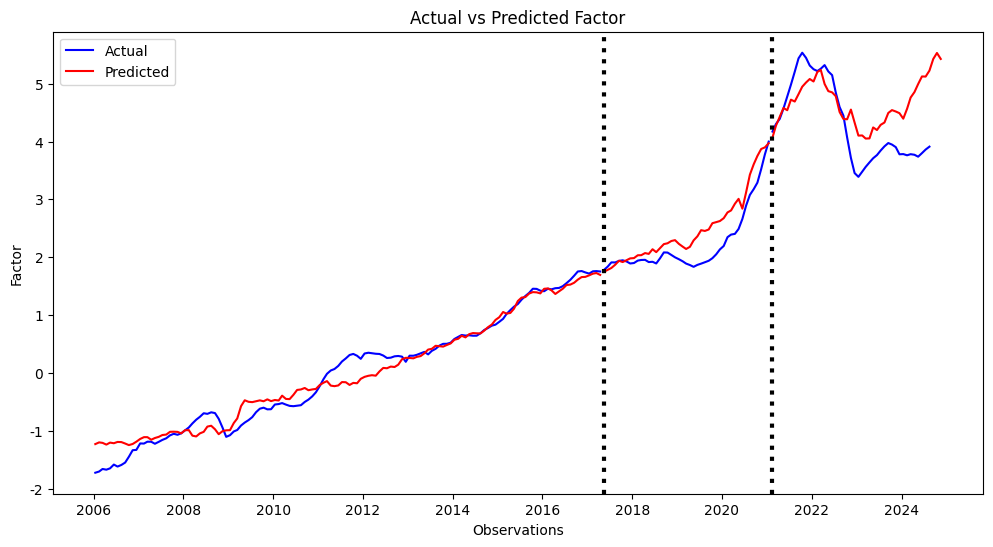

In [23]:
factor2_df = train_sem("factor2")

Target = Common Factor + Individual

In [24]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

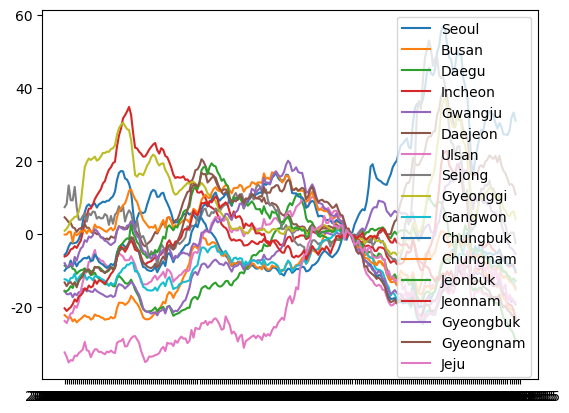

In [25]:
resid = pd.DataFrame([])
for i in range(len(fa.loadings_)):
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = data.iloc[:,i] - f*100/f[142]
    resid[target_column[i]] = f 
    plt.plot(f,label = target_column[i])
plt.legend()
plt.show()
    

### Resid & setting data

In [26]:
nf = pd.read_csv(feature_path).T
nf.columns = nf.iloc[0]
nf = nf.iloc[1:]
for col in nf.columns:
    nf[col] = pd.to_numeric(nf[col], errors='coerce')
nf = pd.concat([nf,resid],axis=1)
_df = pd.concat([df,resid],axis=1)
_df_dropna = _df.dropna()

In [ ]:
# target = "Gyeonggi"
# for i in df.columns:
#     print("p-value:{:.4f}".format(stats.pearsonr(_df_dropna[i], _df_dropna[target])[1]))
#     plt.scatter(_df_dropna[i], _df_dropna[target],c="b")
#     plt.title(f'Relationship of {i} and target')
#     plt.xlabel(f'{i}')
#     plt.ylabel('target')
#     plt.grid(True)
#     plt.show()

In [ ]:
date = 'Date'
resid = resid.reset_index(names=date) 

In [ ]:
resid[date] = pd.to_datetime(resid[date])

resid.reset_index(drop=True, inplace=True)
resid.index.name = "num"

resid

### Deep Learning Model

In [214]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_, test_df_, mean_dict, std_dict

def time_slide_df(df, window_size, forecast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        # x: features from the past window_size (including columns)
        x = df_.loc[idx:idx+window_size-1, target].values 
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        # return self.X[idx], self.Y[idx]
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x,y

In [215]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()

        self.seq_len = configs.seq_len  # Input 길이
        self.pred_len = configs.pred_len  # Output 길이
        self.c_in = configs.enc_in  # 채널 개수

        self.fc1 = nn.Linear(self.seq_len, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, self.pred_len)  # Output 크기를 pred_len으로 설정

    def forward(self, x):
        """
        x: [Batch, Input, Channel]
        output: [Batch, Output, Channel]
        """

        # (B, Input, Channel) → (B, Channel, Input) 변환 (채널별 독립적 학습을 위함)
        x = x.permute(0, 2, 1)  

        # MLP 연산
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)  # (B, Channel, Output)

        # 원래 형태로 되돌리기 (B, Output, Channel)
        x = x.permute(0, 2, 1)
        return x


 40%|████      | 403/1000 [00:26<00:39, 15.25it/s]


Early stopping triggered.


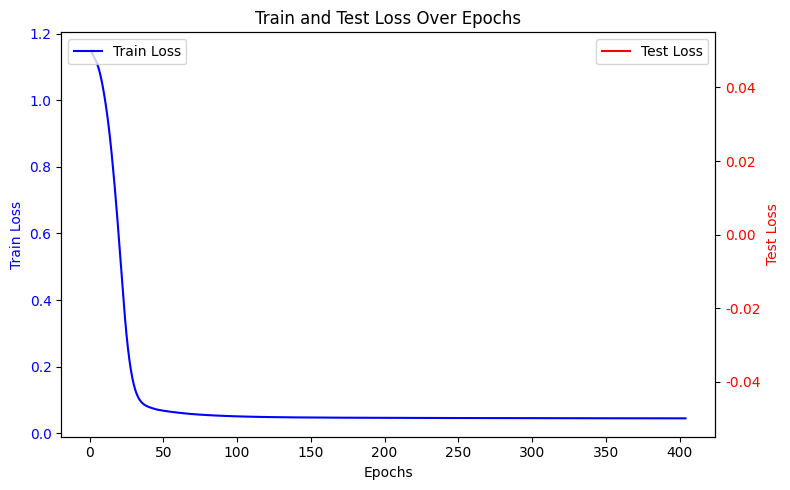

In [216]:
window_size = 3
forecast_size= 3 

train_df = resid[0:185]
test_df = resid[185-forecast_size-window_size+1:]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

version = "V0"
batch_size = 16
epoch_ = 1000
lr = 0.0001
patience = 20  # easrly stopping

columns_to_use = resid.columns[1:]

configs = Namespace( # Convert configs dictionary to Namespace
    seq_len = window_size,
    pred_len = forecast_size,
    enc_in = len(columns_to_use), # feature_size
)

# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./model{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate 
    

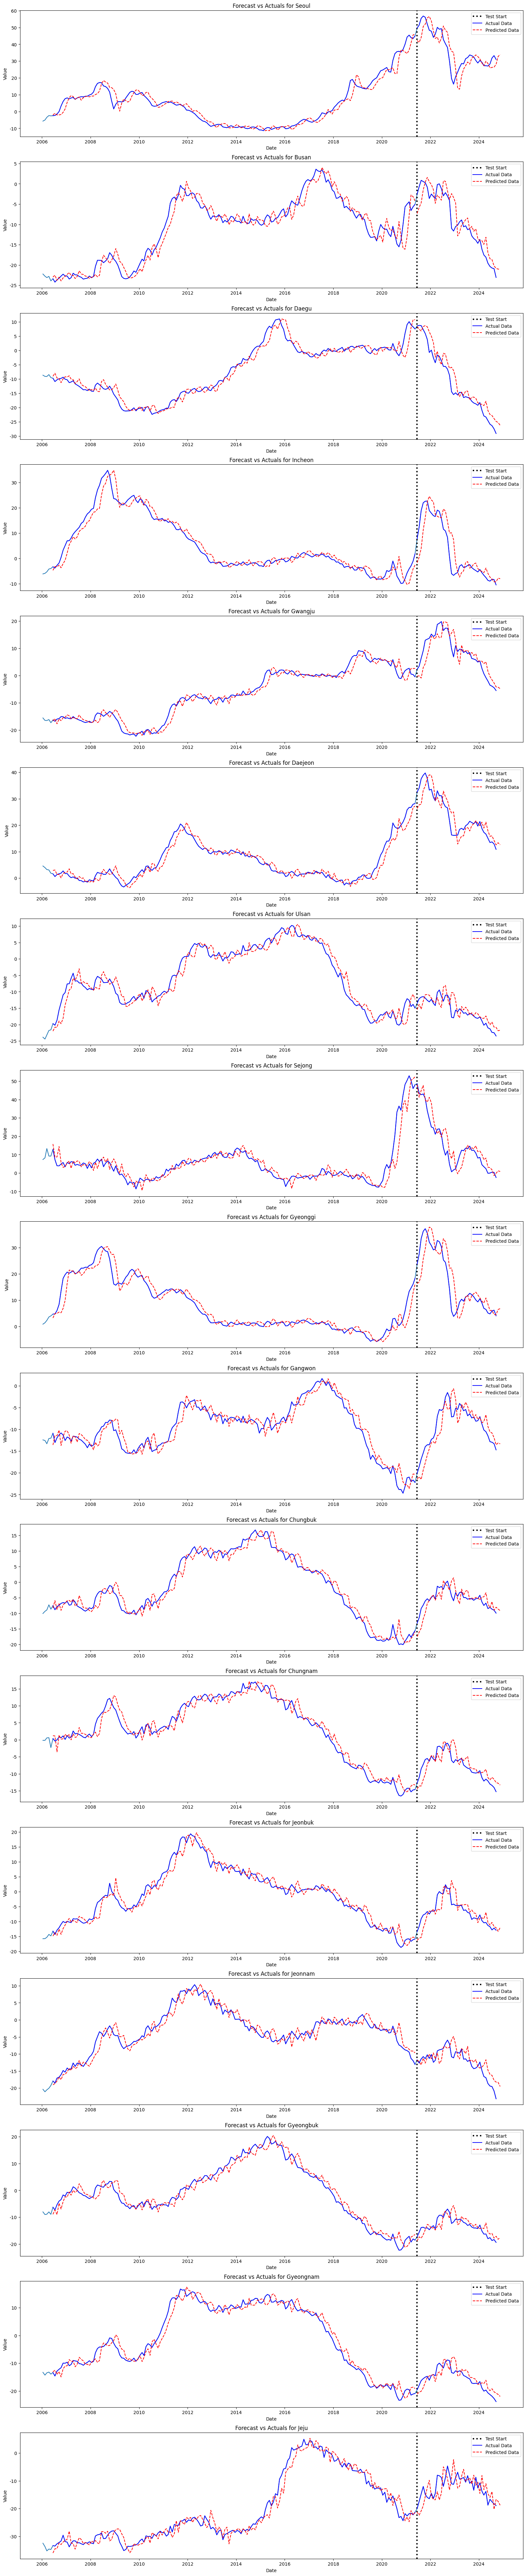

In [230]:
model.load_state_dict(torch.load(f"./model{version}.pth"))  # 최적 모델 로드
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  


    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    # common factors 
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = f*100/f[142]
    
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(resid['Date'], resid[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()       

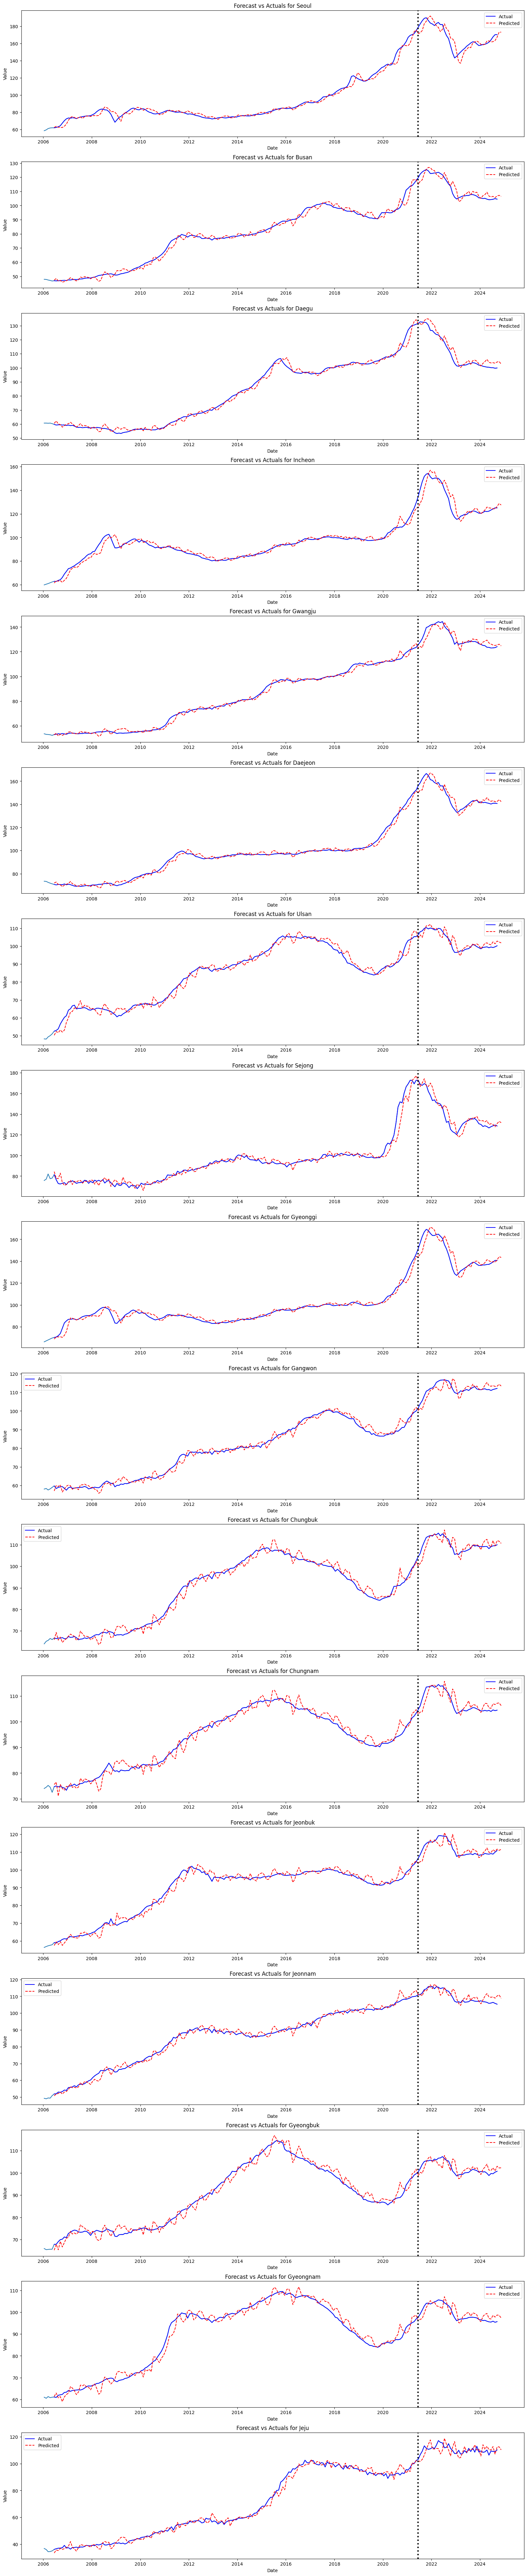

In [234]:
plt.figure(figsize=(20, len(columns_to_use) * 6))
for i in range(len(columns_to_use)):
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = f*100/f[142]
    
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    mask = ~np.isnan(real) & ~np.isnan(pred)
    real_clean = real[mask]
    pred_clean = pred[mask]

    # 정제된 데이터로 RMSE와 R2 계산
    rmse = mean_squared_error(real_clean, pred_clean)**0.5
    r2 = r2_score(real_clean, pred_clean)

    val = [columns_to_use[i], rmse, r2]
    pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    
    act = np.concatenate((train_actual[:, i], test_actual[:,i])) *idv_std+idv_mean
    pre = np.concatenate((train_predicted[:, i], test_predicted[:,i])) *idv_std+idv_mean 
    dat = np.concatenate((train_dates,test_dates))
    
    f_pd = pd.DataFrame(f.values, index = pd.to_datetime(f.index))
    act_pd = pd.DataFrame(act, index = pd.to_datetime(dat))
    pre_pd = pd.DataFrame(pre, index = pd.to_datetime(dat))
    
    plt.subplot(len(columns_to_use), 1, i + 1)
    
    plt.plot(pd.to_datetime(nf.index),nf[nf.columns[i]])
    plt.plot(act_pd.add(f_pd).index, act_pd.add(f_pd),c='b',label="Actual")
    plt.plot(pre_pd.add(f_pd).index, pre_pd.add(f_pd),c='r',label="Predicted", linestyle='--')
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3)
    
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()       